## Load Data

In [1]:
import numpy as np, pandas as pd, os
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score
from sklearn.svm import NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

print(len(train))
train.head()

FileNotFoundError: File b'../input/train.csv' does not exist

# Step 1 and 2 - Build first QDA model and predict test

In [2]:
# # search optimal reg_param

# # INITIALIZE VARIABLES
# cols = [c for c in train.columns if c not in ['id', 'target']]
# cols.remove('wheezy-copper-turtle-magic')
# oof = np.zeros(len(train))
# preds = np.zeros(len(test))

# scores = []
# cand = np.arange(0.1, 1.0, 0.1)

# for reg in cand:

#     # BUILD 512 SEPARATE MODELS
#     for i in range(512):
#         # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
#         train2 = train[train['wheezy-copper-turtle-magic']==i]
#         test2 = test[test['wheezy-copper-turtle-magic']==i]
#         idx1 = train2.index; idx2 = test2.index
#         train2.reset_index(drop=True,inplace=True)

#         # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
#         sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
#         train3 = sel.transform(train2[cols])
#         test3 = sel.transform(test2[cols])
        
        
# #         pca = PCA(n_components=2)
# #         trans = pca.fit_transform(train3)
# #         fig = plt.figure()
# #         label1 = np.where(train2["target"].values==1)
# #         label0 = np.where(train2["target"].values==0)
        
# #         plt.scatter(trans[label1,0], trans[label1,1])
# #         plt.scatter(trans[label0,0], trans[label0,1])
# #         plt.show()
# #         plt.close()
        

#         # STRATIFIED K-FOLD
#         skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
#         for train_index, test_index in skf.split(train3, train2['target']):

#             # MODEL AND PREDICT WITH QDA
#             clf = QuadraticDiscriminantAnalysis(reg_param=reg)
#             clf.fit(train3[train_index,:],train2.loc[train_index]['target'])
#             oof[idx1[test_index]] = clf.predict_proba(train3[test_index,:])[:,1]
#             preds[idx2] += clf.predict_proba(test3)[:,1] / skf.n_splits

#         #if i%64==0: print(i)

#     # PRINT CV AUC
#     auc = roc_auc_score(train['target'],oof)
#     scores.append(auc)
#     print('reg:{} QDA scores CV = {}'.format(reg, round(auc,5)))
    
# best_reg = cand[np.argmax(scores)]
# # print("best reg:{} score;{}".format(best_reg, np.max(scores)))

In [3]:
best_reg=0.6

In [4]:
cols = [c for c in train.columns if c not in ['id', 'target']]

def low_high_var_feats(df):
    low_vars = []
    high_vars = []
    
    for feat in cols:
        if df[feat].var() < 3.0:
            low_vars.append(feat)
        else:
            high_vars.append(feat)
    return low_vars, high_vars

In [5]:
# for i in range(512):
#     # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
#     train2 = train[train['wheezy-copper-turtle-magic']==i]
#     test2 = test[test['wheezy-copper-turtle-magic']==i]
#     idx1 = train2.index; idx2 = test2.index
#     train2.reset_index(drop=True,inplace=True)
    
#     var = []
#     for feat in cols:
#         var.append(train2[feat].var())
#     plt.hist(var, bins=30)
#     plt.show()
#     plt.close()

In [6]:
from sklearn.covariance import GraphicalLasso

def get_mean_cov(x,y):
    model = GraphicalLasso()
    ones = (y==1).astype(bool)
    x2 = x[ones]
    model.fit(x2)
    p1 = model.precision_
    m1 = model.location_
    
    onesb = (y==0).astype(bool)
    x2b = x[onesb]
    model.fit(x2b)
    p2 = model.precision_
    m2 = model.location_
    
    ms = np.stack([m1,m1,m1,m2,m2,m2])
    ps = np.stack([p1,p1,p1,p2,p2,p2])
    return ms,ps

In [7]:
# make initial means, precisions for six clusters.

def cluster_analysis(X_label0, X_label1):
    gmm_label0 = GaussianMixture(n_components=3, covariance_type="full", init_params="kmeans").fit(X_label0)
    gmm_label1 = GaussianMixture(n_components=3, covariance_type="full", init_params="kmeans").fit(X_label1)
    
    ms = np.vstack([gmm_label0.means_, gmm_label1.means_])
    ps = np.vstack([gmm_label0.precisions_, gmm_label1.precisions_])
    return ms, ps

In [8]:
# import warnings
# warnings.filterwarnings('ignore')

# # INITIALIZE VARIABLES
# cols = [c for c in train.columns if c not in ['id', 'target']]
# cols.remove('wheezy-copper-turtle-magic')
# oof_qda = np.zeros(len(train))
# preds_qda = np.zeros(len(test))

# # BUILD 512 SEPARATE MODELS
# for i in range(512):
#     # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
#     train2 = train[train['wheezy-copper-turtle-magic']==i]
#     test2 = test[test['wheezy-copper-turtle-magic']==i]
#     idx1 = train2.index; idx2 = test2.index
#     train2.reset_index(drop=True,inplace=True)
    
#     low, high = low_high_var_feats(train2)
    
#     # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
# #     sel = VarianceThreshold(threshold=2.5).fit(train2[cols])
# #     train3 = sel.transform(train2[cols])
# #     test3 = sel.transform(test2[cols])

#     train3 = train2[high].values
#     test3 = test2[high].values

#     # STRATIFIED K-FOLD
#     skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
#     for train_index, test_index in skf.split(train3, train2['target']):

#         # MODEL AND PREDICT WITH QDA
#         clf_qda = QuadraticDiscriminantAnalysis(reg_param=best_reg)
#         clf_qda.fit(train3[train_index,:],train2.loc[train_index]['target'])
#         oof_qda[idx1[test_index]] = clf_qda.predict_proba(train3[test_index,:])[:,1]
#         preds_qda[idx2] += clf_qda.predict_proba(test3)[:,1] / skf.n_splits

#     #if i%64==0: print(i)

# # PRINT CV AUC
# auc = roc_auc_score(train['target'],oof_qda)
# print('QDA scores CV = {}'.format(round(auc,5)))

## Gaussian Mixture

In [9]:
import warnings
warnings.filterwarnings('ignore')


# INITIALIZE VARIABLES
cols = [c for c in train.columns if c not in ['id', 'target']]
cols.remove('wheezy-copper-turtle-magic')
oof_gmm = np.zeros(len(train))
preds_gmm = np.zeros(len(test))

oof_qda = np.zeros(len(train))
oof = np.zeros(len(train))

preds_qda = np.zeros(len(test))
preds = np.zeros(len(test))

feature_wise_score = []

# BUILD 512 SEPARATE MODELS
for i in tqdm(range(512)):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)
    
#     low, high = low_high_var_feats(train2)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=2.5).fit(np.vstack((train2[cols], test2[cols])))
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
#     train3 = train2[high].values
#     test3 = test2[high].values
    
#     scaler = StandardScaler()
#     scaler.fit(np.vstack((train3, test3)))
#     train3 = scaler.transform(train3)
#     test3 = scaler.transform(test3)

    # STRATIFIED K-FOLD
    skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train3, train2['target']):

        # GMM
#         ms, ps = get_mean_cov(train3[train_index,:],train2.loc[train_index]['target'].values)
#         display()
        label0_indices = np.where(train2["target"].values==0)[0]
        label1_indices = np.where(train2["target"].values==1)[0]
#         print(label0_indices, label1_indices)
#         print(train_index)
#         print(train3.shape)
        ms, ps = cluster_analysis(train3[label0_indices], train3[label1_indices])
#         print(ms)
        
        gm = GaussianMixture(n_components=6, covariance_type='full', 
                             tol=0.001,reg_covar=0.001, max_iter=100, n_init=1,
                             means_init=ms, precisions_init=ps, random_state=1)
        
        gm.fit(np.concatenate([train3[train_index,:],test3],axis = 0))
#         oof_gmm[idx1[test_index]] = gm.predict_proba(train3[test_index,:])[:,0]
        oof_gmm[idx1[test_index]] = np.sum(gm.predict_proba(train3[test_index,:])[:,3:], axis=1)
#         preds_gmm[idx2] += gm.predict_proba(test3)[:,0] / skf.n_splits
        preds_gmm[idx2] += np.sum(gm.predict_proba(test3)[:,3:], axis=1) / skf.n_splits

        
        # QDA
        clf_qda = QuadraticDiscriminantAnalysis(reg_param=best_reg)
        clf_qda.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof_qda[idx1[test_index]] = clf_qda.predict_proba(train3[test_index,:])[:,1]
        preds_qda[idx2] += clf_qda.predict_proba(test3)[:,1] / skf.n_splits
    
    gmm_feature_score = roc_auc_score(train["target"][idx1], oof_gmm[idx1])
    qda_feature_score = roc_auc_score(train["target"][idx1], oof_qda[idx1])
    print("GMM score:{} QDA score:{}".format(gmm_feature_score, qda_feature_score))
    
    if gmm_feature_score < qda_feature_score:
        oof[idx1] = oof_qda[idx1]
        preds[idx2] = preds_qda[idx2]
    else:
        oof[idx1] = oof_gmm[idx1]
        preds[idx2] = preds_gmm[idx2]


# PRINT CV AUC
gmm_auc = roc_auc_score(train['target'],oof_gmm)
qda_auc = roc_auc_score(train['target'],oof_qda)
auc = roc_auc_score(train['target'],oof)

print('GMM scores CV = {}'.format(round(gmm_auc,5)))
print('QDA scores CV = {}'.format(round(qda_auc,5)))
print('Agged scores CV = {}'.format(round(auc,5)))

GMM score:0.9634714407980581 QDA score:0.9568700629972078
GMM score:0.9711443705346144 QDA score:0.9625754496181326
GMM score:0.9734388268338885 QDA score:0.9680416748317983
GMM score:0.9873783181245412 QDA score:0.9754766883143859
GMM score:0.974164225077004 QDA score:0.9639621365787695
GMM score:0.9728403430693509 QDA score:0.9646025523888118
GMM score:0.9878141546722351 QDA score:0.9827876799164741
GMM score:0.9647544056992877 QDA score:0.954107299087614
GMM score:0.982896379525593 QDA score:0.9721818315341118
GMM score:0.9727244031221303 QDA score:0.9703856749311295
GMM score:0.9583978577881016 QDA score:0.9733352690669763
GMM score:0.98375 QDA score:0.9751379310344828
GMM score:0.9805024798764127 QDA score:0.9737539637368893
GMM score:0.9644765957446809 QDA score:0.9733872340425531
GMM score:0.9848106215150279 QDA score:0.979812661498708
GMM score:0.981323717226354 QDA score:0.9744572158365262
GMM score:0.969677680256418 QDA score:0.9739088757750951
GMM score:0.9868558202274749 QD

In [10]:
# import warnings
# warnings.filterwarnings('ignore')
# from sklearn.mixture import GaussianMixture
# from tqdm import tqdm_notebook as tqdm

# # INITIALIZE VARIABLES
# cols = [c for c in train.columns if c not in ['id', 'target']]
# cols.remove('wheezy-copper-turtle-magic')
# oof_gmm = np.zeros(len(train))
# preds_gmm = np.zeros(len(test))

# oof_qda = np.zeros(len(train))
# oof = np.zeros(len(train))

# preds_qda = np.zeros(len(test))

# feature_wise_score = []

# # BUILD 512 SEPARATE MODELS
# for i in tqdm(range(512)):
#     # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
#     train2 = train[train['wheezy-copper-turtle-magic']==i]
#     test2 = test[test['wheezy-copper-turtle-magic']==i]
#     idx1 = train2.index; idx2 = test2.index
#     train2.reset_index(drop=True,inplace=True)
    
# #     low, high = low_high_var_feats(train2)
    
#     # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
#     sel = VarianceThreshold(threshold=2.5).fit(np.vstack((train2[cols], test2[cols])))
#     train3 = sel.transform(train2[cols])
#     test3 = sel.transform(test2[cols])

# #     train3 = train2[high].values
# #     test3 = test2[high].values
    
# #     pca = PCA(n_components=10)
# #     train3 = pca.fit_transform(train3)
# #     test3 = pca.fit_transform(test3)
#     scaler = StandardScaler()
#     scaler.fit(np.vstack((train3, test3)))
#     train3 = scaler.transform(train3)
#     test3 = scaler.transform(test3)

#     # STRATIFIED K-FOLD
#     skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
#     for train_index, test_index in skf.split(train3, train2['target']):

#         # GMM
#         ms, ps = get_mean_cov(train3[train_index,:],train2.loc[train_index]['target'].values)
#         gm = GaussianMixture(n_components=6, init_params='random', covariance_type='full', 
#                              tol=0.001,reg_covar=0.001, max_iter=100, n_init=1, means_init=ms, precisions_init=ps)
        
#         gm.fit(np.concatenate([train3[train_index,:],test3],axis = 0))
# #         oof_gmm[idx1[test_index]] = gm.predict_proba(train3[test_index,:])[:,0]
#         oof_gmm[idx1[test_index]] = np.sum(gm.predict_proba(train3[test_index,:])[:,:3], axis=1)
# #         preds_gmm[idx2] += gm.predict_proba(test3)[:,0] / skf.n_splits
#         preds_gmm[idx2] += np.sum(gm.predict_proba(test3)[:,:3], axis=1) / skf.n_splits

        
#         # QDA
#         clf_qda = QuadraticDiscriminantAnalysis(reg_param=best_reg)
#         clf_qda.fit(train3[train_index,:],train2.loc[train_index]['target'])
#         oof_qda[idx1[test_index]] = clf_qda.predict_proba(train3[test_index,:])[:,1]
#         preds_qda[idx2] += clf_qda.predict_proba(test3)[:,1] / skf.n_splits
    
#     gmm_feature_score = roc_auc_score(train["target"][idx1], oof_gmm[idx1])
#     qda_feature_score = roc_auc_score(train["target"][idx1], oof_qda[idx1])
#     print("GMM score:{} QDA score:{}".format(gmm_feature_score, qda_feature_score))
    
#     if gmm_feature_score < qda_feature_score:
#         oof[idx1] = oof_qda[idx1]
#     else:
#         oof[idx1] = oof_gmm[idx1]


# # PRINT CV AUC
# gmm_auc = roc_auc_score(train['target'],oof_gmm)
# qda_auc = roc_auc_score(train['target'],oof_qda)
# auc = roc_auc_score(train['target'],oof)

# print('GMM scores CV = {}'.format(round(gmm_auc,5)))
# print('QDA scores CV = {}'.format(round(qda_auc,5)))
# print('Agged scores CV = {}'.format(round(auc,5)))

In [11]:
# cand = np.arange(0, 1, 0.01)
# scores = []
# for alpha in cand:
#     score = roc_auc_score(train['target'],alpha*oof_qda+(1-alpha)*oof_gmm)
# #     print("alpha: {} blending AUC: {}".format(alpha, score))
#     scores.append(score)

# alpha = cand[np.argmax(scores)]
# print("best alpha: {} AUC: {}".format(alpha, np.max(scores)))

In [12]:
# preds = alpha*preds_qda+(1-alpha)*preds_gmm
# oof = alpha*oof_qda+(1-alpha)*oof_gmm

In [13]:
# # # INITIALIZE VARIABLES
# cols = [c for c in train.columns if c not in ['id', 'target']]
# cols.remove('wheezy-copper-turtle-magic')
# oof_svm = np.zeros(len(train))
# preds = np.zeros(len(test))

# # BUILD 512 SEPARATE MODELS
# for i in range(512):
#     # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
#     train2 = train[train['wheezy-copper-turtle-magic']==i]
#     test2 = test[test['wheezy-copper-turtle-magic']==i]
#     idx1 = train2.index; idx2 = test2.index
#     train2.reset_index(drop=True,inplace=True)
    
#     # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
#     sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
#     train3 = sel.transform(train2[cols])
#     test3 = sel.transform(test2[cols])
    
#     # STRATIFIED K-FOLD
#     skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
#     for train_index, test_index in skf.split(train3, train2['target']):
        
#         # MODEL AND PREDICT WITH QDA
#         clf_svm = NuSVC(probability=True, kernel='poly', degree=4, random_state=4, nu=0.59, coef0=0.053, gamma="scale")
#         clf_svm.fit(train3[train_index,:],train2.loc[train_index]['target'])
#         oof_svm[idx1[test_index]] = clf_svm.predict_proba(train3[test_index,:])[:,1]
#         preds[idx2] += clf_svm.predict_proba(test3)[:,1] / skf.n_splits
       
#     #if i%64==0: print(i)
        
# # PRINT CV AUC
# auc = roc_auc_score(train['target'],oof_svm)
# print('QDA scores CV =',round(auc,5))

## Check inversed labels

In [14]:
# def BCE(y_true, y_pred):
#     ent = []
#     eps = 1e-10
#     for label, pred in zip(y_true, y_pred):
#         pred = max(eps, min(1-eps, pred))
#         ent.append(-(label*np.log(pred) + (1-label)*np.log(1-pred)))
#     return np.asarray(ent)
    
# oof_log_loss = BCE(train["target"], oof)
# print(oof_log_loss.shape)

# fig = plt.figure(figsize=(10,8))
# plt.hist(oof_log_loss, bins=100)
# plt.show()

In [15]:
# clean_data_idx = np.where(oof_log_loss < 20)[0]
# inversed_data_idx = np.where(oof_log_loss > 20)[0]

In [16]:
# len(clean_data_idx), len(inversed_data_idx)

> ## Inverse labels of inversed data in train, then fit QDA

In [17]:
# # INITIALIZE VARIABLES
# cols = [c for c in train.columns if c not in ['id', 'target']]
# cols.remove('wheezy-copper-turtle-magic')

# # train_cleaned = train.loc[clean_data_idx, :].reset_index(drop=True)
# # print("clean train df {}==>{}".format(len(train), len(train_cleaned)))
# train_modified = train.copy()
# train_modified.loc[inversed_data_idx]["target"] = train_modified.loc[inversed_data_idx]["target"].map({0 : 1, 1: 0})

# oof_qda = np.zeros(len(train_modified))
# preds_qda = np.zeros(len(test))


# # BUILD 512 SEPARATE MODELS
# for i in range(512):
#     # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
#     train2 = train_modified[train_modified['wheezy-copper-turtle-magic']==i]
#     test2 = test[test['wheezy-copper-turtle-magic']==i]
#     idx1 = train2.index; idx2 = test2.index
#     train2.reset_index(drop=True,inplace=True)

#     # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
#     sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
#     train3 = sel.transform(train2[cols])
#     test3 = sel.transform(test2[cols])
    
#     scaler = StandardScaler()
#     scaler.fit(np.vstack((train3, test3)))
#     train3 = scaler.transform(train3)
#     test3 = scaler.transform(test3)

#     # STRATIFIED K-FOLD
#     skf = StratifiedKFold(n_splits=15, random_state=42, shuffle=True)
#     for train_index, test_index in skf.split(train3, train2['target']):

#         # MODEL AND PREDICT WITH QDA
#         clf_qda = QuadraticDiscriminantAnalysis(reg_param=0.6)
#         clf_qda.fit(train3[train_index,:],train2.loc[train_index]['target'])
#         oof_qda[idx1[test_index]] = clf_qda.predict_proba(train3[test_index,:])[:,1]
#         preds_qda[idx2] += clf_qda.predict_proba(test3)[:,1] / skf.n_splits
        
    
# # PRINT CV AUC
# auc = roc_auc_score(train_modified['target'],oof_qda)
# print('QDA scores CV = {}'.format(round(auc,5)))
# auc = roc_auc_score(train['target'],oof_qda)
# print('QDA scores CV = {}'.format(round(auc,5)))

# Step 3 & 4 - Add pseudo label data and build second model 

In [18]:
# train = train_modified

In [19]:
# # INITIALIZE VARIABLES
# test['target'] = preds
# oof_qda = np.zeros(len(train))
# # oof_gmm = np.zeros(len(train))
# oof = np.zeros(len(train))

# preds_qda = np.zeros(len(test))
# # preds_gmm = np.zeros(len(test))
# preds = np.zeros(len(test))


# # BUILD 512 SEPARATE MODELS
# for k in range(512):
#     # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
#     train2 = train[train['wheezy-copper-turtle-magic']==k] 
#     train2p = train2.copy(); idx1 = train2.index 
#     test2 = test[test['wheezy-copper-turtle-magic']==k]
    
#     # ADD PSEUDO LABELED DATA
#     test2p = test2[ (test2['target']<=0.01) | (test2['target']>=0.99) ].copy()
#     test2p.loc[ test2p['target']>=0.5, 'target' ] = 1
#     test2p.loc[ test2p['target']<0.5, 'target' ] = 0 
#     train2p = pd.concat([train2p,test2p],axis=0)
#     train2p.reset_index(drop=True,inplace=True)
    
#     # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
#     sel = VarianceThreshold(threshold=1.5).fit(train2p[cols])     
#     train3p = sel.transform(train2p[cols])
#     train3 = sel.transform(train2[cols])
#     test3 = sel.transform(test2[cols])
    
#     scaler = StandardScaler()
#     scaler.fit(np.vstack((train3, test3)))
#     train3 = scaler.transform(train3)
#     train3p = scaler.transform(train3p)
#     test3 = scaler.transform(test3)
    
        
#     # STRATIFIED K FOLD
#     skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
#     for train_index, test_index in skf.split(train3p, train2p['target']):
#         test_index3 = test_index[ test_index<len(train3) ] # ignore pseudo in oof
        
#         # MODEL AND PREDICT WITH QDA
#         clf = QuadraticDiscriminantAnalysis(reg_param=0.6)
#         clf.fit(train3p[train_index,:],train2p.loc[train_index]['target'])
#         oof_qda[idx1[test_index3]] = clf.predict_proba(train3[test_index3,:])[:,1]
#         preds_qda[test2.index] += clf.predict_proba(test3)[:,1] / skf.n_splits
                
# # PRINT CV AUC
# auc = roc_auc_score(train['target'],oof_qda)
# print('Pseudo Labeled QDA scores CV =',round(auc,5))

In [20]:
# # GMM
# # INITIALIZE VARIABLES
# test['target'] = preds
# oof_gmm = np.zeros(len(train))
# preds_gmm = np.zeros(len(test))

# # BUILD 512 SEPARATE MODELS
# for k in range(512):
#     # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
#     train2 = train[train['wheezy-copper-turtle-magic']==k] 
#     train2p = train2.copy(); idx1 = train2.index 
#     test2 = test[test['wheezy-copper-turtle-magic']==k]
    
#     # ADD PSEUDO LABELED DATA
#     test2p = test2[ (test2['target']<=0.005) | (test2['target']>=0.995) ].copy()
#     test2p.loc[ test2p['target']>=0.5, 'target' ] = 1
#     test2p.loc[ test2p['target']<0.5, 'target' ] = 0 
#     train2p = pd.concat([train2p,test2p],axis=0)
#     train2p.reset_index(drop=True,inplace=True)
    
#     # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
#     sel = VarianceThreshold(threshold=1.5).fit(train2p[cols])     
#     train3p = sel.transform(train2p[cols])
#     train3 = sel.transform(train2[cols])
#     test3 = sel.transform(test2[cols])
        
#     # STRATIFIED K FOLD
#     skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
#     for train_index, test_index in skf.split(train3p, train2p['target']):
#         test_index3 = test_index[ test_index<len(train3) ] # ignore pseudo in oof
        
#         # MODEL AND PREDICT WITH GMM
#         ms, ps = get_mean_cov(train3p[train_index,:],train2p.loc[train_index]['target'].values)
        
#         gm = GaussianMixture(n_components=2, init_params='random', covariance_type='full', tol=0.001,reg_covar=0.001, max_iter=100, n_init=1,means_init=ms, precisions_init=ps)
#         gm.fit(np.concatenate([train3p[train_index,:],test3],axis = 0))
#         oof_gmm[idx1[test_index3]] = gm.predict_proba(train3[test_index3,:])[:,0]
#         preds_gmm[test2.index] += gm.predict_proba(test3)[:,0] / skf.n_splits
       
#     #if k%64==0: print(k)
        
# # PRINT CV AUC
# auc = roc_auc_score(train['target'],oof_gmm)
# print('Pseudo Labeled QDA scores CV =',round(auc,5))

In [21]:
# import numpy as np
# cand = np.arange(0,1,0.01)
# scores = []
# for alpha in np.arange(0,1,0.01):
#     score = roc_auc_score(train['target'],alpha*oof_qda+(1-alpha)*oof_gmm)
#     print("alpha: {} blending AUC: {}".format(alpha, score))
#     scores.append(score)

# alpha = cand[np.argmax(scores)]
# print("best alpha: ", alpha)

In [22]:
# preds = alpha*preds_qda+(1-alpha)*preds_gmm
# oof = alpha*oof_qda+(1-alpha)*oof_gmm

# Submit Predictions

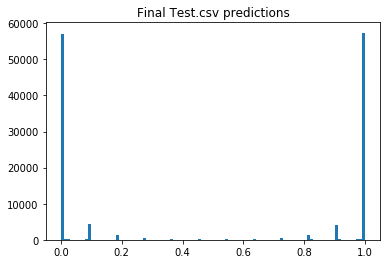

In [23]:
sub = pd.read_csv('../input/sample_submission.csv')
sub['target'] = preds
sub.to_csv('submission.csv',index=False)

import matplotlib.pyplot as plt
plt.hist(preds,bins=100)
plt.title('Final Test.csv predictions')
plt.show()

# Conclusion
In this kernel, we learned what pseudo labeling is, why it works, and how to deploy it. Using it on the data from Instant Gratification competition we observed it increase CV by an impressive 0.005! Pseudo labeling QDA achieved CV 0.970 and LB 0.969. Without pseudo labeling, QDA achieved CV 0.965 and LB 0.965.

When you run your kernel locally, it will only pseudo label the public test data (because that is all that `test.csv` contains). When you submit this solution to Kaggle, your submission will load the full `test.csv` and pseudo label both the public and private test data set. Thus you will approximately double your amount of training data for your submissions!